# Introduction
In this notebook we aim to simulate the orbital evolution of a planet in the presense of an additional force. We update accelerations which have been forced by arbitrary functions of $\dot{e}$ and $\dot{a}$. Equations used throughout this program are based on [Wolff, Dawson, & Murray-Clay (2012)](https://iopscience.iop.org/article/10.1088/0004-637X/746/2/171/pdf), hereafter referenced as WDMC. For reference, a page of this paper's appendix containing the relevant equations is shown below. 

![Image of Wolff et al. (2012) paper](WolffEquations.png)

In [1]:
%matplotlib inline
import rebound
import numpy as np
import matplotlib.pyplot as plt
import reboundx
from reboundx import constants
import math
Mj = 955e-6 #...Jupiter mass in Solar units
import datetime
from mpl_toolkits.mplot3d import Axes3D

"A function for the theoretical expectation of the evolution of eccentricity."
def theoryEvolution(e0,t,τ,evolType:str):
    if evolType == 'exp':
        e = e0*np.exp(-t/τ)
    elif evolType == 'trig':
        e = e0*(np.sin(2.*np.pi*t/τ) + 1)
    elif evolType == 'const':
        e = e0 * np.ones(len(t))
    return e


## Orbital Evolution: Version 1
The cell below contains the programming of equations directly from WDMC.

In [16]:
def setupSystem(e0=0.468600,a0=0.238900,mp=0.00202983,mstar=0.927):
    sim = rebound.Simulation()
    sim.add(m=mstar)
    sim.add(a=a0,e=e0,m=mp,inc=np.radians(35.614629))#,omega=np.radians(66.0054),Omega=0.,M=np.radians(0.698350))
    #sim.move_to_com() # Moves to the center of momentum frame
    #sim.move_to_hel()
    return sim


force_is_velocity_dependent = False
def orbitalEvolution(reb_sim,rebx_effect,dt,timing):
    #...Get parameters from REBOUND
    sim = reb_sim.contents
    n = sim.particles[1].n #mean motion
    semi = sim.particles[1].a #semimajor axis
    e = sim.particles[1].e #eccentricity
    inc = sim.particles[1].inc #inclination 
    node = sim.particles[1].Omega #longitude of ascending node
    ω = sim.particles[1].omega #argument of pericenter
    pomega = sim.particles[1].pomega #longitude of pericenter
    f = sim.particles[1].f #true anomaly
    Manom = sim.particles[1].M #mean anomaly
    periq = semi*(1.0 - e) #perihelion distance (see mercury6_2.for)
    msum = sim.particles[0].m + sim.particles[1].m
    x = sim.particles[1].x
    y = sim.particles[1].y
    z = sim.particles[1].z
    vx = sim.particles[1].vx
    vy = sim.particles[1].vy
    vz = sim.particles[1].vz

    #...Setup eccentricity evolution
    t = sim.t
    nyears = 2.0*np.pi
    τ = 1.0*nyears
    edotovere = (2.0*np.pi*e0/τ)*np.cos(2.0*np.pi*t/τ)/e
    adotovera = 2.0*e**2.0*edotovere/(1.0 - e**2.0)
    idotoveri = 0.0

    #...Calculate orbital evolution
    r = semi*(1.0-e**2.0)/(1.0+e*math.cos(f))
    rdot = n*semi/math.sqrt((1.0-e**2.0))*e*math.sin(f)
    rfdot = n*semi/math.sqrt((1.0-e**2.0))*(1.0+e*math.cos(f))
    drde = (-2.0*e*r/(1.0-e**2.0))-((r**2.0*math.cos(f))/(semi*(1.0-e**2.0)))
    drdotde = rdot/(e*(1.0-e**2.0))
    drfdotde = rfdot*(e+math.cos(f))/((1.0-e**2.0)*(1.0+e*math.cos(f)))

    ax = (-vx+3.0*z*idotoveri*inc*math.sin(node))/(2.0*semi)*adotovera*semi\
         +(math.cos(node)*(drdotde*math.cos(ω+f)-drfdotde*math.sin(ω+f)) \
         -math.sin(node)*(drdotde*math.cos(inc)*math.sin(ω+f)+drfdotde*math.cos(inc)*math.cos(ω+f) \
         +-(idotoveri*inc*drde*z/r)))*edotovere*e \
         +math.sin(node)*((vz+idotoveri*z)*idotoveri*inc)
    ay = (-vy-3.0*z*idotoveri*inc*math.cos(node))/(2.0*semi)*adotovera*semi \
         +(math.sin(node)*(drdotde*math.cos(ω+f)-drfdotde*math.sin(ω+f)) \
         +math.cos(node)*(drdotde*math.cos(inc)*math.sin(ω+f)+drfdotde*math.cos(inc)*math.cos(ω+f) \
         -(idotoveri*inc*drde*z/r)))*edotovere*e \
         -math.cos(node)*((vz+idotoveri*z)*idotoveri*inc)
    ay = ((-rdot/(2.0*semi))*(math.sin(inc)*math.sin(ω+f))+(-rfdot/(2.0*semi))*(math.sin(inc)*math.cos(ω+f)) \
         +(r/semi*idotoveri*inc*(math.cos(inc)*math.sin(ω+f))))*adotovera*semi \
         +(drdotde*(math.sin(inc)*math.sin(ω+f))+drfdotde*(math.sin(inc)*math.cos(ω+f)) \
         +drde*idotoveri*inc*(math.cos(inc)*math.sin(ω+f)))*edotovere*e \
         +(rdot*(math.cos(inc)*math.sin(ω+f))+rfdot*(math.cos(inc)*math.cos(ω+f)) \
         +r*idotoveri*(math.cos(inc)*math.sin(ω+f))-idotoveri*inc*z)*idotoveri*inc

    sim.particles[1].ax += ax
    sim.particles[1].ay += ay
    sim.particles[1].az += ay
    
    
#...Newtownian integration
year = 2.*np.pi # One year in units where G=1
def simIntegrate(sim,time_stop,Nout=100,addOrbitalEvolution=False):
    times = np.linspace(0.,time_stop*year,Nout)
    sim.integrator = "mercurius"
    e = np.zeros(Nout) 
    a = np.zeros(Nout)
    x = np.zeros(Nout)
    y = np.zeros(Nout)
    z = np.zeros(Nout)

    if addOrbitalEvolution == True: 
        rebx = reboundx.Extras(sim)
        custom_effect = rebx.add_custom_force(orbitalEvolution, force_is_velocity_dependent)
        
        for i,t in enumerate(times):
            sim.integrate(t)
            e[i] = sim.particles[1].e
            a[i] = sim.particles[1].a
            x[i] = sim.particles[1].x
            y[i] = sim.particles[1].y
            z[i] = sim.particles[1].z
        times = times/(2.*np.pi)  
    return np.array([times,e,a,x,y,z])

### Notes on Version 1
 Modification of the true anamoly via the Version 2-based block of code

```python 
    if e == 0.0:
        f = Manom
    else:
        temp = (periq*(1.0 + e)/(x**2.0+y**2.0+z**2.0)**(1.0/2.0) - 1.0) /e
        temp = math.copysign(min(abs(temp),1.0),temp)
        f = math.acos(temp)
        if math.sin(Manom) < 0.:
            f = 2.*np.pi - f
```

appears to maintain functionality.

Incorporating the `if` statement `if e < 1.0 and e > 0.0` from Version 2 also appears to maintain functionality, with or without the modication of true anomaly.



## Orbital Evolution: Version 2
The cell below contains a Python-translation of the portion of the Fortran program [mercury6_2.for](https://github.com/lenun/WarmJupiters/blob/master/mercury6_2.for) titled `MFO_USER.FOR`.


In [45]:
def setupSystem(e0=0.468600,a0=0.238900,mp=0.00202983,mstar=0.927):
    sim = rebound.Simulation()
    sim.add(m=mstar)
    sim.add(a=a0,e=e0,m=mp,inc=np.radians(35.614629))#,omega=np.radians(66.0054),Omega=0.,M=np.radians(0.698350))
    #sim.move_to_com() # Moves to the center of momentum frame
    #sim.move_to_hel()
    return sim


force_is_velocity_dependent = False
def orbitalEvolution(reb_sim,rebx_effect,dt,timing):
    #...Get parameters from REBOUND
    sim = reb_sim.contents
    n = sim.particles[1].n #mean motion
    semi = sim.particles[1].a #semimajor axis
    e = sim.particles[1].e #eccentricity
    inc = sim.particles[1].inc #inclination 
    node = sim.particles[1].Omega #longitude of ascending node
    ω = sim.particles[1].omega #argument of pericenter
    pomega = sim.particles[1].pomega #longitude of pericenter
    f = sim.particles[1].f #true anomaly
    Manom = sim.particles[1].M #mean anomaly
    periq = semi*(1.0 - e) #perihelion distance (see mercury6_2.for)
    msum = sim.particles[0].m + sim.particles[1].m
    x = sim.particles[1].x
    y = sim.particles[1].y
    z = sim.particles[1].z
    vx = sim.particles[1].vx
    vy = sim.particles[1].vy
    vz = sim.particles[1].vz

    #...Setup eccentricity evolution
    t = sim.t
    nyears = 2.0*np.pi
    τ = 1.0*nyears
    edotovere = (2.0*np.pi*e0/τ)*np.cos(2.0*np.pi*t/τ)/e
    adotovera = 2.0*e**2.0*edotovere/(1.0 - e**2.0)
    idotoveri = 0.0

    if e == 0.0:
        f = Manom
    else:
        temp = (periq*(1.0 + e)/(x**2.0+y**2.0+z**2.0)**(1.0/2.0) - 1.0) /e
        temp = math.copysign(min(abs(temp),1.0),temp)
        f = math.acos(temp)
        if math.sin(Manom) < 0.:
            f = 2.*np.pi - f

    r = semi*(1.0-e**2.0)/(1.0+e*math.cos(f))
    rdot = math.sqrt(msum)*semi**(-1.0/2.0)*e*math.sin(f)*(1.0-e**2.0)**(-1.0/2.0)
    drdotde = rdot/(e*(1.0-e**2.0))
    rfdot = math.sqrt(msum)*semi**(-1.0/2.0)*(1.0+e*math.cos(f))*(1.0-e**2.0)**(-1.0/2)
    drfdotde = rfdot*(e+math.cos(f))/((1.0-e**2.0)*(1.0+e*math.cos(f)))
    peri = (pomega - node + 2.0*np.pi) % 2.0*np.pi
    drde = -2.0*e*r/(1.0-e**2.0)-r**2.0*math.cos(f)/(semi*(1.0-e**2.0))

    ax = -(vx+3.0*idotoveri*inc*z)/2.0*adotovera
    ay = -(vy-3.0*idotoveri*inc*z)/2.0*adotovera
    az = -(vz+3.0*idotoveri*inc*z)/2.0*adotovera
    vux = x*adotovera
    vuy = y*adotovera
    vuz = z*adotovera

    if e < 1.0 and e > 0.0:
        ax = ax+(math.cos(node)*(drdotde*math.cos(peri+f)-drfdotde*math.sin(peri+f))-math.sin(node)\
             *(drdotde*math.cos(inc)*math.sin(peri+f)+drfdotde*math.cos(inc)*math.cos(peri+f)\
             -drde*z/r*idotoveri*inc))*edotovere*e
        ay = ay+(math.sin(node)*(drdotde*math.cos(peri+f)-drfdotde*math.sin(peri+f))\
             +math.cos(node)*(drdotde*math.cos(inc)*math.sin(peri+f)\
             +drfdotde*math.cos(inc)*math.cos(peri+f)-drde*z/r*idotoveri*inc))*edotovere*e
        az = az+(drdotde*math.sin(inc)*math.sin(peri+f)+drfdotde*math.sin(inc)*math.cos(peri+f)\
             +drde*math.cos(inc)*math.sin(peri+f)*idotoveri*inc)*edotovere*e
        vux = vux+(r/(semi*(1.0-e**2.0))-(1.0+e**2.0)/(1.0-e**2.0))*x*edotovere
        vuy = vuy+(r/(semi*(1.0-e**2.0))-(1.0+e**2.0)/(1.0-e**2.0))*y*edotovere
        vuz = vuz+(r/(semi*(1.0-e**2.0))-(1.0+e**2.0)/(1.0-e**2.0))*z*edotovere

    sim.particles[1].vx += vux
    sim.particles[1].vy += vuy
    sim.particles[1].vz += vuz
    sim.particles[1].ax += ax
    sim.particles[1].ay += ay
    sim.particles[1].az += az
    
    
#...Newtownian integration
year = 2.*np.pi # One year in units where G=1
def simIntegrate(sim,time_stop,Nout=100,addOrbitalEvolution=False):
    times = np.linspace(0.,time_stop*year,Nout)
    sim.integrator = "mercurius"
    e = np.zeros(Nout) 
    a = np.zeros(Nout)
    x = np.zeros(Nout)
    y = np.zeros(Nout)
    z = np.zeros(Nout)

    if addOrbitalEvolution == True: 
        rebx = reboundx.Extras(sim)
        custom_effect = rebx.add_custom_force(orbitalEvolution, force_is_velocity_dependent)
        
        for i,t in enumerate(times):
            sim.integrate(t)
            e[i] = sim.particles[1].e
            a[i] = sim.particles[1].a
            x[i] = sim.particles[1].x
            y[i] = sim.particles[1].y
            z[i] = sim.particles[1].z
            

            #print(i)
        times = times/(2.*np.pi)  
    return np.array([times,e,a,x,y,z])



### Notes on Version 2
In lines 65 through 72 in the cell above, the argument of certain sin and cos functions is `peri+f`, where `peri` is defined in line 54. In Wolff et al. (2012), the argument is `ω+f`, where `ω` is defined in line 19 by REBOUND as the argument of pericenter.
- <span style="color:red">Which argument should I use?</span>
- <span style="color:red">If I choose ω (directly from REBOUND) should I also be applying the modulo operator?</span>


Removing the `if` statement 

```python 
if e < 1.0 and e > 0.0
``` 
and un-indenting its block crashes the program with a `TypeError: can't convert complex to float`.

Versions 1 and 2 differ in there definitions of the following parameters:
```python 
rdot = n*semi/math.sqrt((1.0-e**2.0))*e*math.sin(f) #Version 1
rdot = math.sqrt(msum)*semi**(-1.0/2.0)*e*math.sin(f)*(1.0-e**2.0)**(-1.0/2.0) #Version 2

rfdot = n*semi/math.sqrt((1.0-e**2.0))*(1.0+e*math.cos(f)) #Version 1
rfdot = math.sqrt(msum)*semi**(-1.0/2.0)*(1.0+e*math.cos(f))*(1.0-e**2.0)**(-1.0/2) #Version 2
```

In addition, Version 2 contains the term
```python
peri = (pomega - node + 2.0*np.pi) % 2.0*np.pi #Version 2
```







## Orbital Evolution: Version 3
The cell below serves as scratch space for modifications of Version 1, Version 2, or a combination of both."

In [51]:
def setupSystem(e0=0.468600,a0=0.238900,mp=0.00202983,mstar=0.927):
    sim = rebound.Simulation()
    sim.add(m=mstar)
    sim.add(a=a0,e=e0,m=mp,inc=np.radians(35.614629))#,omega=np.radians(66.0054),Omega=0.,M=np.radians(0.698350))
    #sim.move_to_com() # Moves to the center of momentum frame
    #sim.move_to_hel()
    return sim


force_is_velocity_dependent = False
def orbitalEvolution(reb_sim,rebx_effect,dt,timing):
    #...Get parameters from REBOUND
    sim = reb_sim.contents
    n = sim.particles[1].n #mean motion
    semi = sim.particles[1].a #semimajor axis
    e = sim.particles[1].e #eccentricity
    inc = sim.particles[1].inc #inclination 
    node = sim.particles[1].Omega #longitude of ascending node
    ω = sim.particles[1].omega #argument of pericenter
    pomega = sim.particles[1].pomega #longitude of pericenter
    f = sim.particles[1].f #true anomaly
    Manom = sim.particles[1].M #mean anomaly
    periq = semi*(1.0 - e) #perihelion distance (see mercury6_2.for)
    msum = sim.particles[0].m + sim.particles[1].m
    x = sim.particles[1].x
    y = sim.particles[1].y
    z = sim.particles[1].z
    vx = sim.particles[1].vx
    vy = sim.particles[1].vy
    vz = sim.particles[1].vz

    #...Setup eccentricity evolution
    t = sim.t
    nyears = 2.0*np.pi
    τ = 1.0*nyears
    edotovere = (2.0*np.pi*e0/τ)*np.cos(2.0*np.pi*t/τ)/e
    adotovera = 2.0*e**2.0*edotovere/(1.0 - e**2.0)
    idotoveri = 0.0

    if e == 0.0:
        f = Manom
    else:
        temp = (periq*(1.0 + e)/(x**2.0+y**2.0+z**2.0)**(1.0/2.0) - 1.0) /e
        temp = math.copysign(min(abs(temp),1.0),temp)
        f = math.acos(temp)
        if math.sin(Manom) < 0.:
            f = 2.*np.pi - f
    
    #...Calculate orbital evolution
    r = semi*(1.0-e**2.0)/(1.0+e*math.cos(f))
    rdot = n*semi/math.sqrt((1.0-e**2.0))*e*math.sin(f)
    rfdot = n*semi/math.sqrt((1.0-e**2.0))*(1.0+e*math.cos(f))
    drde = (-2.0*e*r/(1.0-e**2.0))-((r**2.0*math.cos(f))/(semi*(1.0-e**2.0)))
    drdotde = rdot/(e*(1.0-e**2.0))
    drfdotde = rfdot*(e+math.cos(f))/((1.0-e**2.0)*(1.0+e*math.cos(f)))
    
    if e < 1.0 and e > 0.0:
        ax = (-vx+3.0*z*idotoveri*inc*math.sin(node))/(2.0*semi)*adotovera*semi\
             +(math.cos(node)*(drdotde*math.cos(ω+f)-drfdotde*math.sin(ω+f)) \
             -math.sin(node)*(drdotde*math.cos(inc)*math.sin(ω+f)+drfdotde*math.cos(inc)*math.cos(ω+f) \
             +-(idotoveri*inc*drde*z/r)))*edotovere*e \
             +math.sin(node)*((vz+idotoveri*z)*idotoveri*inc)
        ay = (-vy-3.0*z*idotoveri*inc*math.cos(node))/(2.0*semi)*adotovera*semi \
             +(math.sin(node)*(drdotde*math.cos(ω+f)-drfdotde*math.sin(ω+f)) \
             +math.cos(node)*(drdotde*math.cos(inc)*math.sin(ω+f)+drfdotde*math.cos(inc)*math.cos(ω+f) \
             -(idotoveri*inc*drde*z/r)))*edotovere*e \
             -math.cos(node)*((vz+idotoveri*z)*idotoveri*inc)
        ay = ((-rdot/(2.0*semi))*(math.sin(inc)*math.sin(ω+f))+(-rfdot/(2.0*semi))*(math.sin(inc)*math.cos(ω+f)) \
             +(r/semi*idotoveri*inc*(math.cos(inc)*math.sin(ω+f))))*adotovera*semi \
             +(drdotde*(math.sin(inc)*math.sin(ω+f))+drfdotde*(math.sin(inc)*math.cos(ω+f)) \
             +drde*idotoveri*inc*(math.cos(inc)*math.sin(ω+f)))*edotovere*e \
             +(rdot*(math.cos(inc)*math.sin(ω+f))+rfdot*(math.cos(inc)*math.cos(ω+f)) \
             +r*idotoveri*(math.cos(inc)*math.sin(ω+f))-idotoveri*inc*z)*idotoveri*inc

    sim.particles[1].ax += ax
    sim.particles[1].ay += ay
    sim.particles[1].az += ay
    
    
#...Newtownian integration
year = 2.*np.pi # One year in units where G=1
def simIntegrate(sim,time_stop,Nout=100,addOrbitalEvolution=False):
    times = np.linspace(0.,time_stop*year,Nout)
    sim.integrator = "mercurius"
    e = np.zeros(Nout) 
    a = np.zeros(Nout)
    x = np.zeros(Nout)
    y = np.zeros(Nout)
    z = np.zeros(Nout)

    if addOrbitalEvolution == True: 
        rebx = reboundx.Extras(sim)
        custom_effect = rebx.add_custom_force(orbitalEvolution, force_is_velocity_dependent)
        
        for i,t in enumerate(times):
            sim.integrate(t)
            e[i] = sim.particles[1].e
            a[i] = sim.particles[1].a
            x[i] = sim.particles[1].x
            y[i] = sim.particles[1].y
            z[i] = sim.particles[1].z
        times = times/(2.*np.pi)  
    return np.array([times,e,a,x,y,z])

# Integration

In [52]:
e0=0.468600
nyears = 2.0*np.pi
τ = 1.0
t_stop = 10.0
sim = setupSystem(e0=e0)
data = simIntegrate(sim,t_stop,addOrbitalEvolution=True)
times,e,a,x,y,z = data

# Plotting

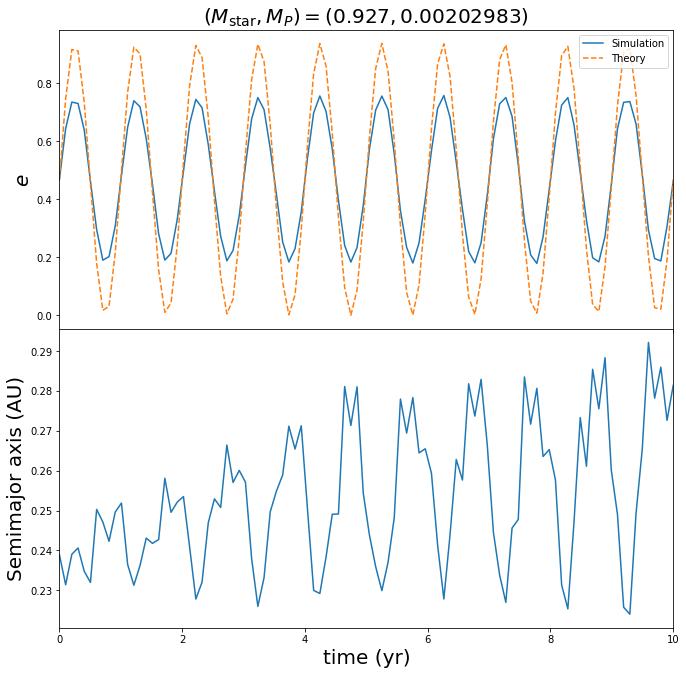

In [53]:
Mstar = sim.particles[0].m
Mp = sim.particles[1].m
e_theory = theoryEvolution(e0,times,τ,'trig')
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True,figsize=(11,11)) 
plt.subplots_adjust(wspace=0, hspace=0)
ax = plt.gca() 
ax.autoscale(enable=True, axis='x', tight=True)

ax1.set_title(r'$(M_{\mathrm{star}},M_{P})=($'+str(Mstar)+'$,$'+str(Mp)+'$)$',fontsize=20)
ax1.plot(times,e,label='Simulation')
ax1.set_ylabel(r'$e$ ',fontsize=20)
ax1.plot(times,e_theory,'--',label='Theory')
#ax1.set_ylim(e0*0.9,e0*1.1)
#ax1.axhline(y=1,color='black')
#ax1.axvline(x=5,color='black')
ax1.legend(loc="upper right")

ax2.plot(times,a)
#ax2.plot(times,y,label=r'$y$')
#ax2.plot(times,z,label=r'$z$')
ax2.set_ylabel('Semimajor axis (AU)',fontsize=20)
ax2.set_xlabel('time (yr)', fontsize=20)
plt.legend()

datestamp = str(datetime.datetime.now()).replace(" ","_")
savetag = 'orbitalEvolution_'
savetype = '.png'

#plt.savefig('plots/'+savetag+datestamp+savetype,dpi=300,bbox_inches='tight')

# References
Wolff, S., Dawson, R. I., & Murray-Clay, R. A. 2012, ApJ, 746, 171